# This notebook is for the Fair-Shapely experiment

In [26]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [ ]:
from src.data.unified_dataloader import load_dataset

a, processed_german_credit = load_dataset('german_credit')
_, processed_adult = load_dataset('adult')

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [ ]:
processed_adult.head(3)

,age,education-num,capital-gain,capital-loss,hours-per-week,sex,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income
0,0.030671,1.134739,0.148453,-0.21666,-0.035429,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0.837109,1.134739,-0.145920,-0.21666,-2.222153,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-0.042642,-0.420060,-0.145920,-0.21666,-0.035429,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


### 3. Split label/unlabel data, split train/test data.

In [ ]:
'''UCI dataset'''
df = processed_adult.copy()
X = df.drop('income', axis=1)
y = df['income']



# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (22792, 106)
X_test shape: (9769, 106)


### 4. Train the original model

In [ ]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8749104309550619


In [ ]:
X_train['sex'].value_counts()

sex
1    15232
0     7560
Name: count, dtype: int64

In [20]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 1
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 0
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]


In [21]:
# male_condition = X_train['sex'] == 1
# X_train_majority = X_train[male_condition]
# y_train_majority = y_train[male_condition]

# female_condition = X_train['sex'] == 0
# X_train_minority = X_train[female_condition]
# y_train_minority = y_train[female_condition]

# # 获取 X_train_minority 和 y_train_minority 的第一行
# first_row_X_train_minority = X_train_minority.iloc[0:1]
# first_row_y_train_minority = y_train_minority.iloc[0:1]

# # 将第一行添加到 X_train_majority 和 y_train_majority
# X_train_majority = pd.concat([X_train_majority, first_row_X_train_minority])
# y_train_majority = pd.concat([y_train_majority, first_row_y_train_minority])

### 5. Evaluate the performance of original model

In [ ]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')

original_test_DR: 0.02362159453332424
original_train_DR: 0.024025436490774155


In [23]:
# from fairlearn.metrics import MetricFrame, selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate,count
# metrics = {'accuracy': accuracy_score,
#            'selection_rate': selection_rate,
#            'false_positive_rate': false_positive_rate,
#            'true_positive_rate': true_positive_rate,
#            'false_negative_rate': false_negative_rate,
#            'true_negative_rate': true_negative_rate,
#               'count': count}
# a_test = X_test['sex']
# mf_original = MetricFrame(metrics=metrics,
#                  y_true=y_test,
#                  y_pred=y_pred,
#                  sensitive_features=a_test)

# print("Test set fairness metrics (before mitigation):")
# mf_original.by_group.plot(
#     kind="bar",
#     subplots=True,
#     layout=[3, 3],
#     legend=False,
#     figsize=[12, 8],
#     colormap="Accent",
#     title="Baseline--train_limited_labeled_data",
# )
# diff = mf_original.by_group


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

3. 将X_train_minority与X_train_replace_majority进行匹配
4. 使用fairshap,把X_train_minority作为baseline dataset，找到X_train_replace_majority中需要替换的数据
未处理前非0值的个数:19105


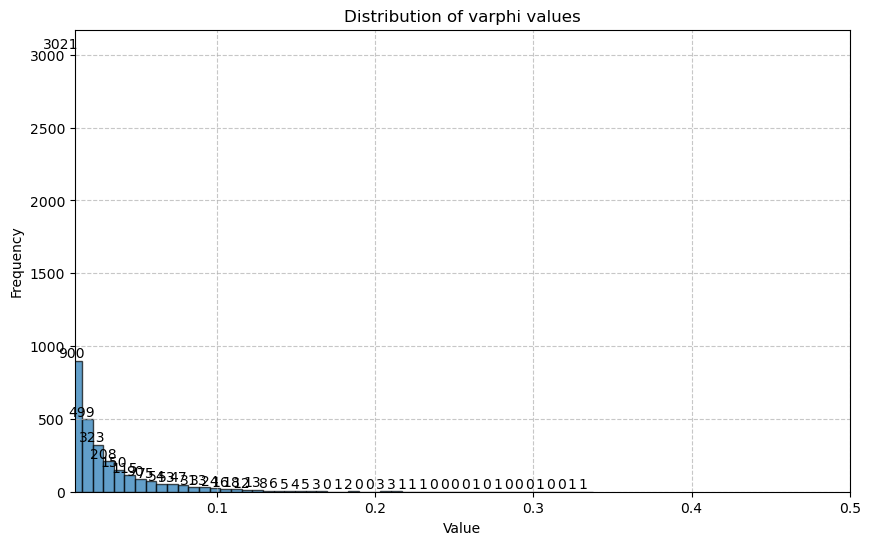

shapley value 大于0.1的值的个数:114
self.original_train_DR: 0.024025436490774155


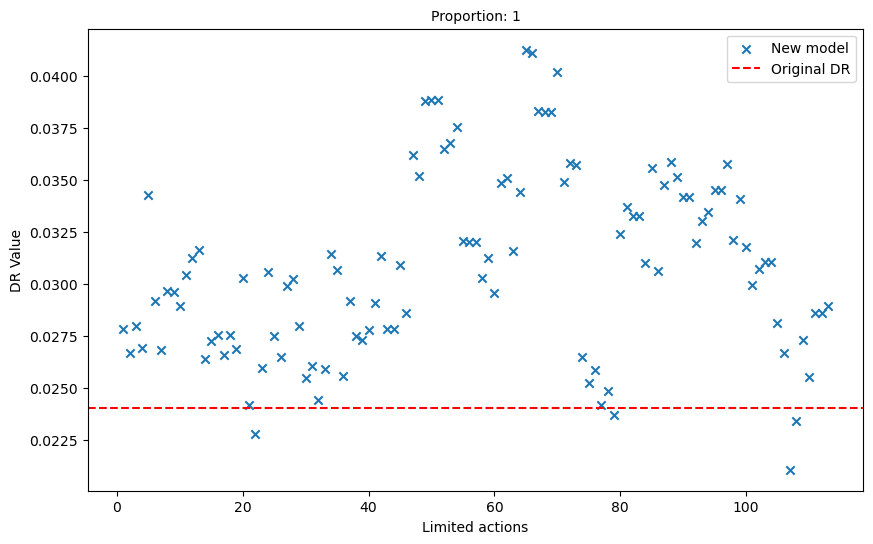

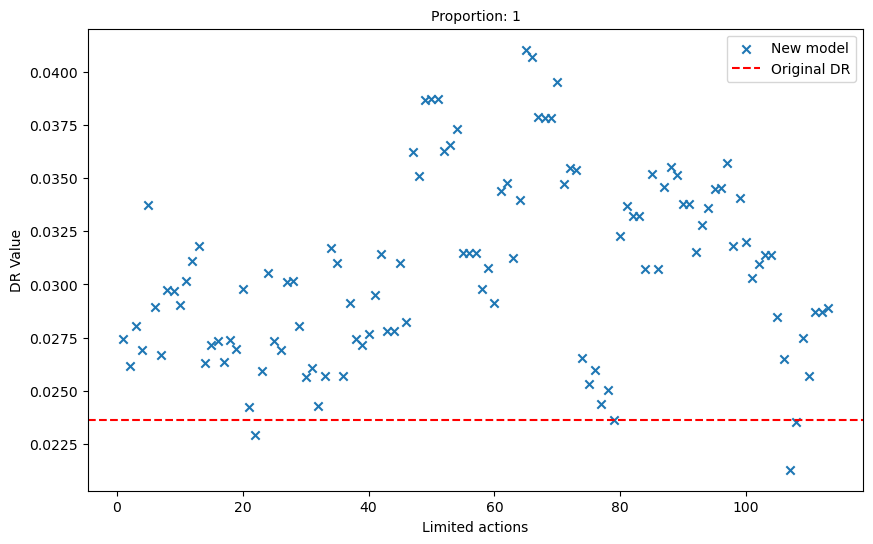

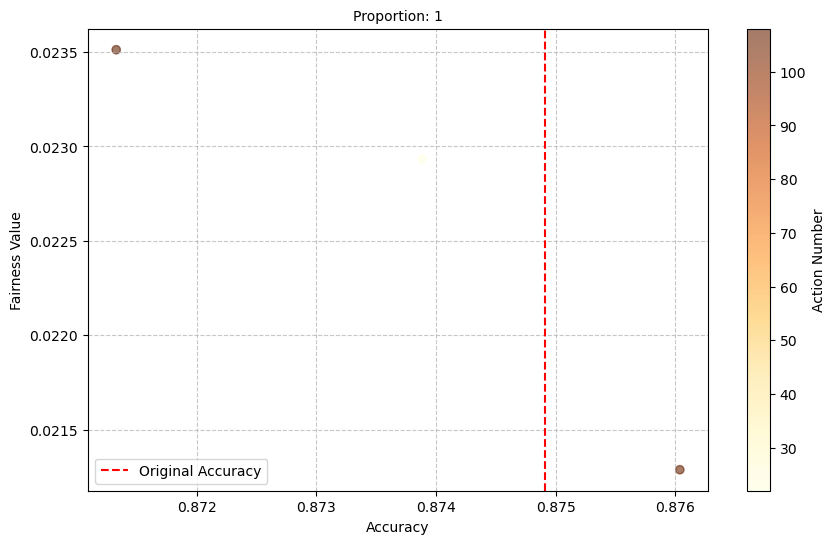

([0.02745255,
  0.02618601,
  0.028036105,
  0.026934044,
  0.033742867,
  0.028954856,
  0.026661184,
  0.029726557,
  0.029703332,
  0.02901948,
  0.030160883,
  0.031085495,
  0.031827424,
  0.0263019,
  0.02715917,
  0.027337518,
  0.026346058,
  0.027364949,
  0.026986979,
  0.029763622,
  0.024216535,
  0.022933317,
  0.025925418,
  0.030537484,
  0.027317388,
  0.026925348,
  0.03009345,
  0.030174818,
  0.028065113,
  0.025647605,
  0.026087455,
  0.024301957,
  0.025697032,
  0.031730063,
  0.031028902,
  0.025716081,
  0.029110536,
  0.027446121,
  0.02713159,
  0.02768999,
  0.029481042,
  0.0314527,
  0.027793448,
  0.027796984,
  0.031028923,
  0.028233515,
  0.03621997,
  0.035104632,
  0.03868811,
  0.03869851,
  0.038699932,
  0.036290307,
  0.036563966,
  0.03729877,
  0.03149262,
  0.03149262,
  0.03149262,
  0.029775823,
  0.030773645,
  0.029144919,
  0.03437938,
  0.034773335,
  0.031231806,
  0.03398643,
  0.041034605,
  0.040704068,
  0.037855834,
  0.03784455,
 

In [ ]:
from src.experiments_approach2 import ExperimentNew

''' 改变minority group中的部分特征值'''

experiment = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='adult',
                            change_group = 'minority')
experiment.run_experiment()

In [25]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='adult',
                            change_group = 'majority')
experiment2.run_experiment()

3. 将X_train_minority与X_train_replace_majority进行匹配
4. 使用fairshap,把X_train_replace_majority作为baseline dataset，找到X_train_minority中需要替换的数据


KeyboardInterrupt: 